# TWAP Analysis

## Purpose
Explore Reflexer RAI/USD Oracle TWAP

## Outline

1) Load Data
2) Prep Data

### Number of most recent minutes to display for all plots

In [1]:
N_PLOTS = 30000

In [2]:
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import scipy.stats as ss

In [3]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 200 

## Load Data

#### Load Chainlink RAI/USD feed data

In [4]:
df_cl = pd.read_csv('cl_rai_usd.csv')
df_cl = df_cl.rename(columns={"RAI / USD": "rai_usd_link", "Answer": "time"})

In [5]:
df_cl.tail(3)

,time,rai_usd_link
23,Wed Oct 27 2021 08:00:00 GMT-0400,3.010000
24,Wed Oct 27 2021 20:00:00 GMT-0400,3.010000
25,Thu Oct 28 2021 08:00:00 GMT-0400,3.032195


#### Load Chainlink ETH/USD data

In [6]:
df_link = pd.read_csv('link_eth.csv.gz')
df_link = df_link.rename(columns={"price": "eth_usd_link", "ts": "time"}).drop(["started_at"], axis=1)
df_link['eth_usd_link'] /= 1E8

In [7]:
df_link.tail(3)

,block,eth_usd_link,time
1375366,13505713,4150.92,1635422132
1375367,13505714,4150.92,1635422132
1375368,13505715,4150.92,1635422132


#### Load prod RAI/USD TWAP data

In [8]:
# Prod RAI/USD TWAP
# RAI/USD values derived from RAI/ETH TWAP and TWAP of Chainlink spot ETH/USD. 
# Time: modified time
# Source: the graph systemState.
df_twap = pd.read_csv('twap.csv')
df_twap = df_twap.rename(columns={"value": "twap_usd"})

In [9]:
df_twap.tail(3)

,time,twap_usd,field
26340,2021-10-26T13:51:32Z,3.034127,currentCoinMedianizerUpdate
26341,2021-10-26T14:02:03Z,3.034127,currentCoinMedianizerUpdate
26342,2021-10-26T14:08:45Z,3.034127,currentCoinMedianizerUpdate


#### Load RAI/ETH uniswap v2 data

In [10]:
# Spot RAI/ETH. 
#Time: modified time
# Source: The graph uniswapPair

df_rai = pd.read_csv('rai_eth.csv')
df_rai = df_rai.rename(columns={"value": "rai_eth"})

In [11]:
df_rai.tail(3)

,time,rai_eth,field
8733,2021-10-26T13:47:55Z,0.000720,RAI/ETH price
8734,2021-10-26T14:02:03Z,0.000724,RAI/ETH price
8735,2021-10-26T14:08:45Z,0.000728,RAI/ETH price


#### Load ETH/USD Coingecko data

In [12]:
# Spot ETH/USD from Coingecko. 
# Time: API query time
df_eth = pd.read_csv('eth_usd.csv')
df_eth = df_eth.rename(columns={"value": "eth_usd_spot"})

In [13]:
df_eth.tail(3)

,time,eth_usd_spot,field
103246,2021-10-26T14:17:03Z,4168.77,ETH/USD price
103247,2021-10-26T14:19:07Z,4170.09,ETH/USD price
103248,2021-10-26T14:21:11Z,4169.00,ETH/USD price


## Prep Data

#### Convert `time` string to UTC datetime 

In [14]:
df_twap['time'] = pd.to_datetime(df_twap['time'], infer_datetime_format=True, utc=True)
df_rai['time'] = pd.to_datetime(df_rai['time'], infer_datetime_format=True, utc=True)
df_eth['time'] = pd.to_datetime(df_eth['time'], infer_datetime_format=True, utc=True)
df_link['time'] = pd.to_datetime(df_link['time'], unit='s', utc=True)
df_cl['time'] = pd.to_datetime(df_cl['time'], infer_datetime_format=True, utc=True)

#### Round each `time` to 1 min

In [15]:
df_twap['time_1m'] = df_twap['time'].dt.round('1min') 
df_rai['time_1m'] = df_rai['time'].dt.round('1min') 
df_eth['time_1m'] = df_eth['time'].dt.round('1min') 
df_link['time_1m'] = df_link['time'].dt.round('1min') 
df_cl['time_1m'] = df_cl['time'].dt.round('1min') 

#### Rounding might have created duplicates, so drop those

In [16]:
df_twap = df_twap.drop_duplicates(['time_1m']) 
df_rai = df_rai.drop_duplicates(['time_1m']) 
df_eth = df_eth.drop_duplicates(['time_1m']) 
df_link = df_link.drop_duplicates(['time_1m']) 
df_cl = df_cl.drop_duplicates(['time_1m']) 

#### Set time index

In [17]:
df_twap = df_twap.set_index('time_1m')
df_rai = df_rai.set_index('time_1m')
df_eth = df_eth.set_index('time_1m')
df_link = df_link.set_index('time_1m')
df_cl = df_cl.set_index('time_1m')

#### Forward fill every minute in between. This will allow joining since each data source has a different set of timestamps

In [18]:
df_twap = df_twap.asfreq('1min', method='ffill')
df_rai = df_rai.asfreq('1min', method='ffill')
df_eth = df_eth.asfreq('1min', method='ffill')
df_link = df_link.asfreq('1min', method='ffill')
df_cl = df_cl.asfreq('1min', method='ffill')

#### Join all dataframes

In [19]:
df_rai_eth = pd.merge(df_rai['rai_eth'], df_eth['eth_usd_spot'], left_index=True, right_index=True)
df_rai_eth_link = pd.merge(df_rai_eth[['rai_eth', 'eth_usd_spot']], df_link['eth_usd_link'], left_index=True, right_index=True)
df = pd.merge(df_rai_eth_link[['rai_eth', 'eth_usd_spot', 'eth_usd_link']], df_twap['twap_usd'], left_index=True, right_index=True)

df = pd.merge(df[['rai_eth', 'eth_usd_spot', 'eth_usd_link', 'twap_usd']], df_cl['rai_usd_link'], left_index=True, right_index=True)

#### Calculate spot RAI/USD from spot RAI/ETH and spot ETH/USD

In [20]:
df['rai_usd'] = df['rai_eth'] * df['eth_usd_spot']

#### Start at first TWAP update

In [65]:
df = df.iloc[168:, :] # First TWAP update

Text(0.5, 1.0, 'ETH/USD')

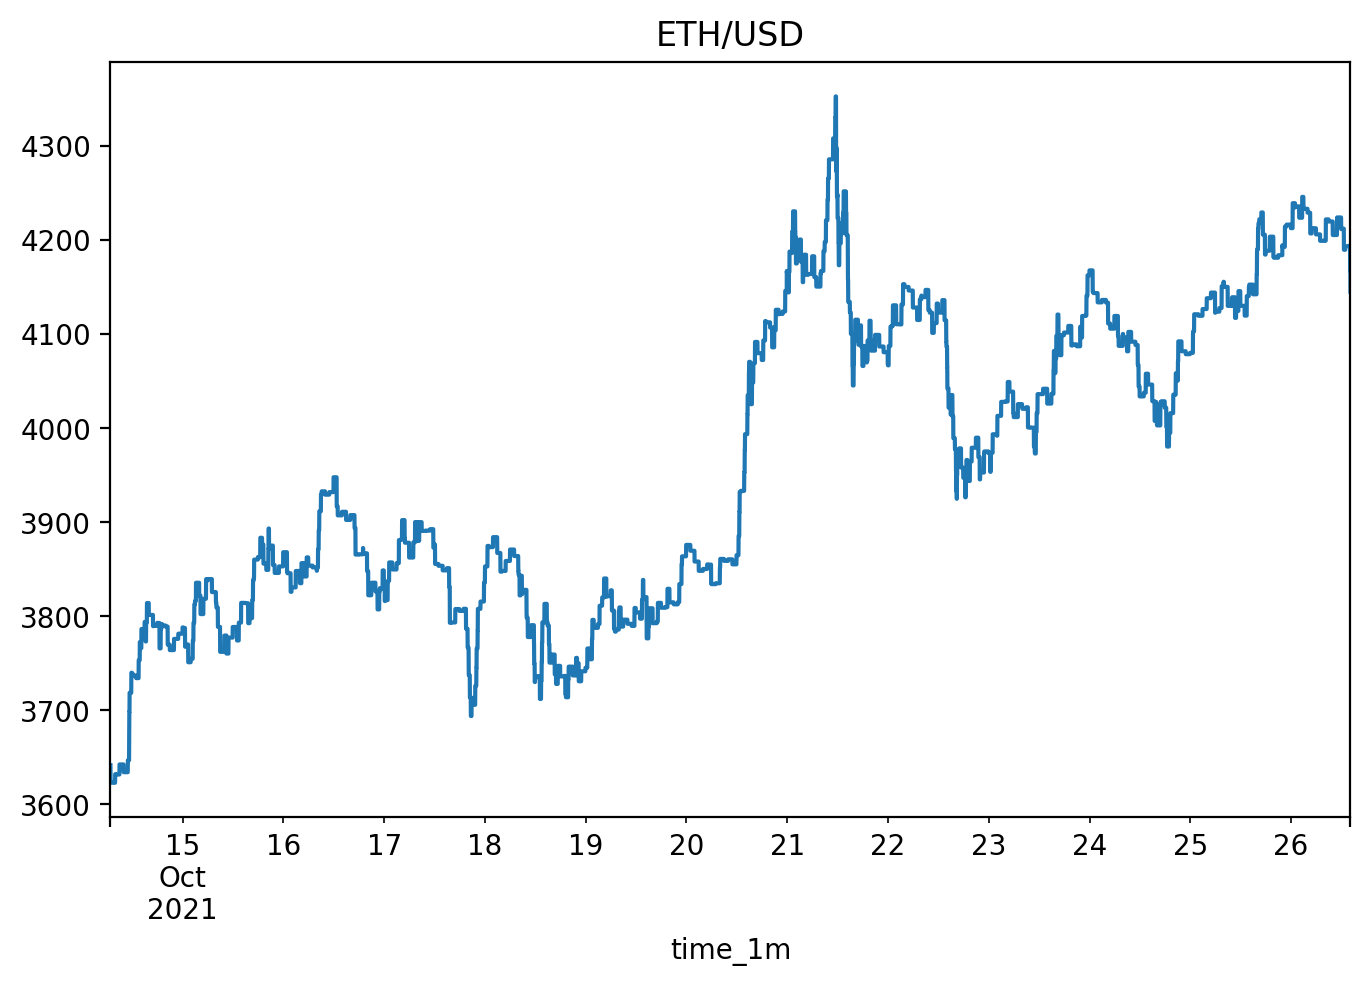

In [66]:
df['eth_usd_link'].iloc[:N_PLOTS].plot()
plt.title('ETH/USD')

# Prod RAI/USD TWAP vs RAI/USD spot

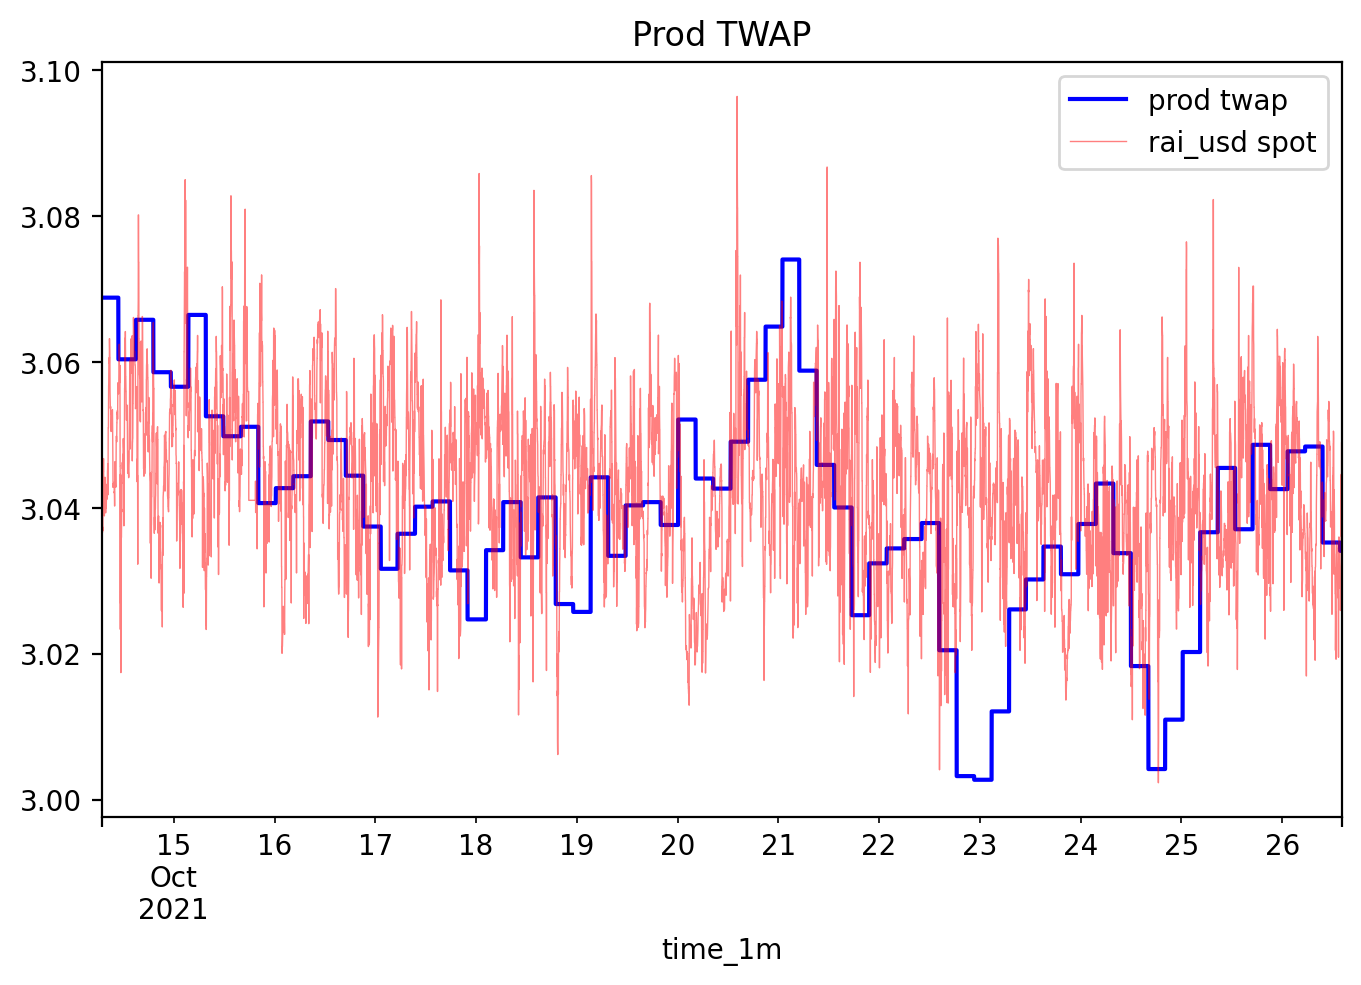

In [67]:
ax = df['twap_usd'][:N_PLOTS].plot(color='blue', label='prod twap')
df['rai_usd'][:N_PLOTS].plot(ax=ax, alpha=0.5, color='red', label='rai_usd spot', lw=0.5)
plt.title('Prod TWAP')
plt.legend()

### Prod TWAP Error

Text(0.5, 1.0, 'Prod TWAP - RAI/USD Spot')

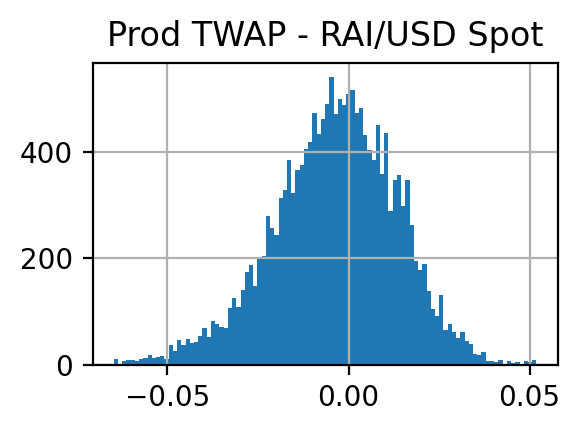

In [68]:
(df['twap_usd'].iloc[:] - df['rai_usd'].iloc[:]).hist(bins=100, figsize=(3,2))
plt.title("Prod TWAP - RAI/USD Spot")

# Reconstruct RAI/USD TWAP 

In [84]:
# Create current, prod TWAP from spot RAI/ETH and spot ETH/USD
def create_prod_twap(df, window_size=16, period_size=4, eth_usd_col='eth_usd'):
    twap_col = '_'.join(map(str, ['rai_usd', window_size, period_size]))
    mean_col = 'rai_eth_mean'
    
    # RAI/ETH window_size mean
    df[mean_col] = df.rolling(str(window_size) + 'H')['rai_eth'].mean()
    
    # period_size samples
    df_twap = df.resample(str(period_size) + 'H').first()[[eth_usd_col, mean_col]]
    
    # ETH/USD window_size mean using samples
    df_twap[eth_usd_col + '_mean'] = df_twap.rolling(str(window_size) + 'H')[eth_usd_col].mean()
    
    df_twap[twap_col] = df_twap[mean_col] * df_twap[eth_usd_col + '_mean']
    
    df_twap =  df_twap.asfreq('1min', method='ffill')

    df_final = pd.merge(df, df_twap, left_index=True, right_index=True).drop([eth_usd_col + '_x', eth_usd_col + '_y'], axis=1)
    
    return df_final 

# Create current, prod TWAP from spot RAI/ETH and spot ETH/USD
def create_prod_twap(df, window_size=16, period_size=4, eth_usd_col='eth_usd'):
    twap_col = '_'.join(map(str, ['rai_usd', window_size, period_size]))
    mean_col = 'rai_eth_mean'
    
    # RAI/ETH window_size mean
    df[mean_col] = df.rolling(str(window_size) + 'H')['rai_eth'].mean()
    
    # period_size samples
    df_twap = df.resample(str(period_size) + 'H').first()[[eth_usd_col, mean_col]]
    
    # ETH/USD window_size mean using samples
    df_twap[eth_usd_col + '_mean'] = df_twap.rolling(str(window_size) + 'H')[eth_usd_col].mean()
    
    df_twap[twap_col] = df_twap[mean_col] * df_twap[eth_usd_col + '_mean']
    
    df_twap =  df_twap.asfreq('1min', method='ffill')

    df_final = pd.merge(df, df_twap, left_index=True, right_index=True).drop([eth_usd_col + '_x', eth_usd_col + '_y'], axis=1)
    
    return df_final 

In [85]:
df_eth_usd_4H['eth_usd_16H'] = df_eth_usd_4H.rolling('16H')['eth_usd'].mean()

NameError: name 'df_eth_usd_4H' is not defined

In [86]:
df_eth_usd_4H.head(5)

NameError: name 'df_eth_usd_4H' is not defined

### Reconstructed TWAP vs prod TWAP

In [87]:
# Create TWAP with prod parameters, window_size=16, period_size=4
df_ethlink = create_prod_twap(df, 16, 4, 'eth_usd_link')
#error = mean_squared_error(df_ethlink['twap_usd'], df_ethlink['rai_usd_16_4'])
#error

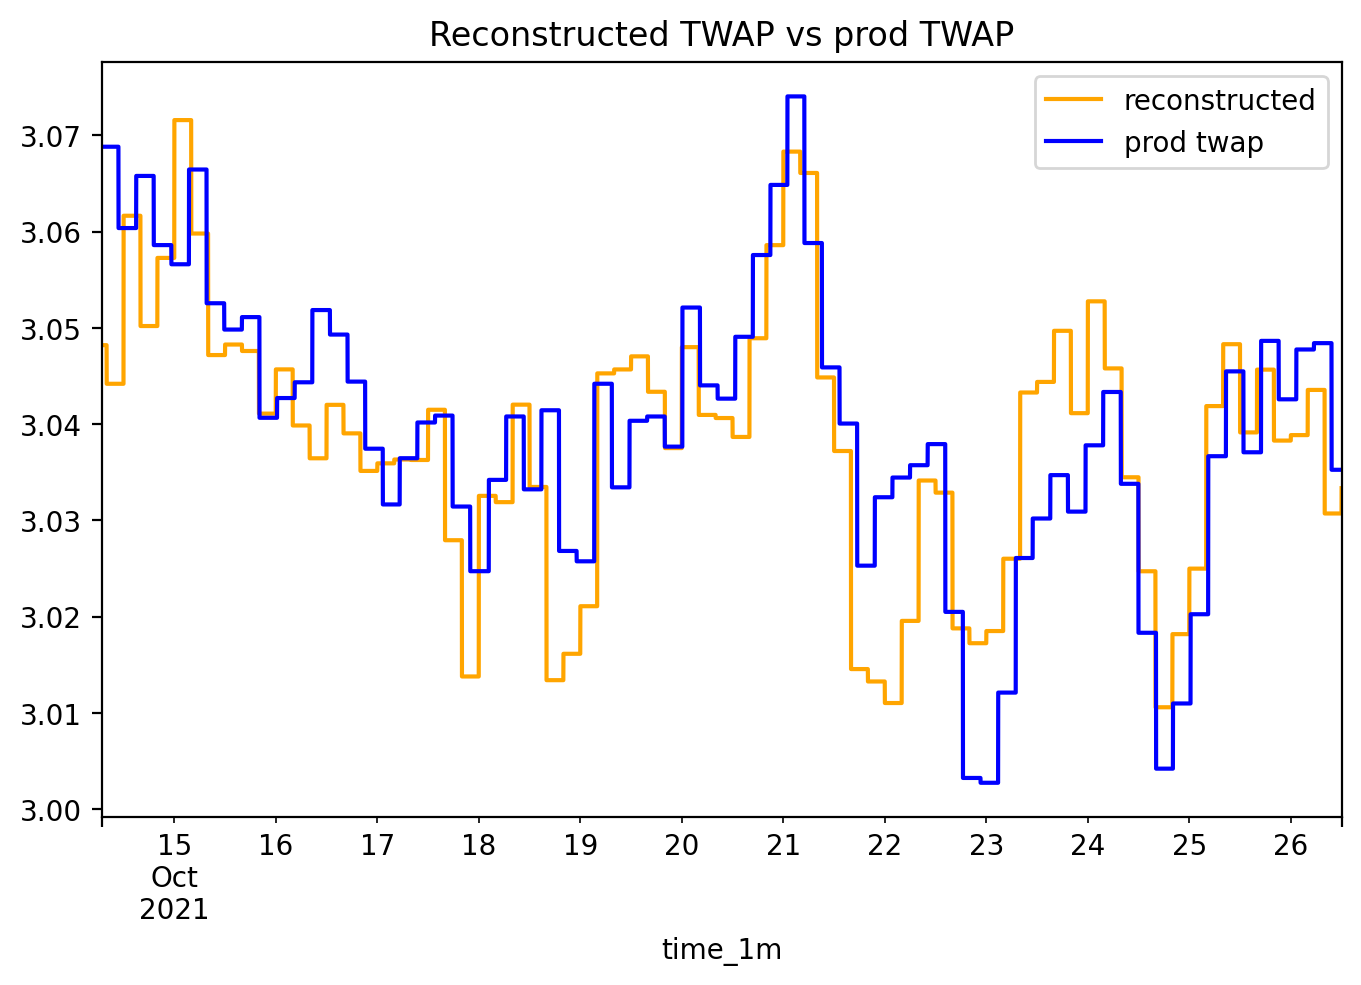

In [88]:
ax = df_ethlink['rai_usd_16_4'][:N_PLOTS].plot(color='orange', label='reconstructed')
df_ethlink['twap_usd'][:N_PLOTS].plot(ax=ax, color='blue', label='prod twap')
plt.title('Reconstructed TWAP vs prod TWAP')
plt.legend()

### Reconstructed TWAP Error

Text(0.5, 1.0, 'Reconstructed TWAP - RAI/USD Spot')

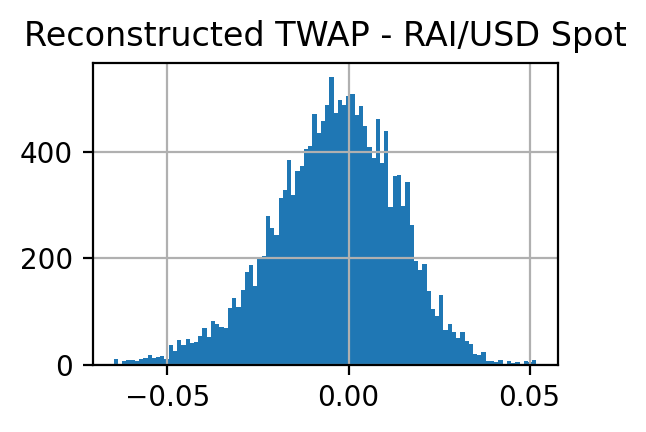

In [33]:
(df_ethlink['twap_usd'].iloc[:] - df_ethlink['rai_usd'].iloc[:]).hist(bins=100, figsize=(3,2))
plt.title("Reconstructed TWAP - RAI/USD Spot")

### Explore TWAPs with different parameters

In [34]:
'''
params = []
for window_size in range(24, 129):
    for period_size in range(8, 25):
        if window_size % period_size != 0:
            continue
        if period_size * 2 > window_size:
            continue
        params.append((window_size, period_size)) 
'''

'\nparams = []\nfor window_size in range(24, 129):\n    for period_size in range(8, 25):\n        if window_size % period_size != 0:\n            continue\n        if period_size * 2 > window_size:\n            continue\n        params.append((window_size, period_size)) \n'

In [35]:
'''
from sklearn.linear_model import LinearRegression
import datetime as dt
lr = LinearRegression()
X = (df.index - dt.datetime(1970,1,1)).seconds.values.reshape(-1,1)
Y = df['rai_usd'].values.reshape(-1,1)
lr.fit(X, Y)  
pred = lr.predict(X)
mean_squared_error(pred, Y)
'''

"\nfrom sklearn.linear_model import LinearRegression\nimport datetime as dt\nlr = LinearRegression()\nX = (df.index - dt.datetime(1970,1,1)).seconds.values.reshape(-1,1)\nY = df['rai_usd'].values.reshape(-1,1)\nlr.fit(X, Y)  \npred = lr.predict(X)\nmean_squared_error(pred, Y)\n"

In [36]:
params = [(16, 4), (24, 8), (40, 8)]

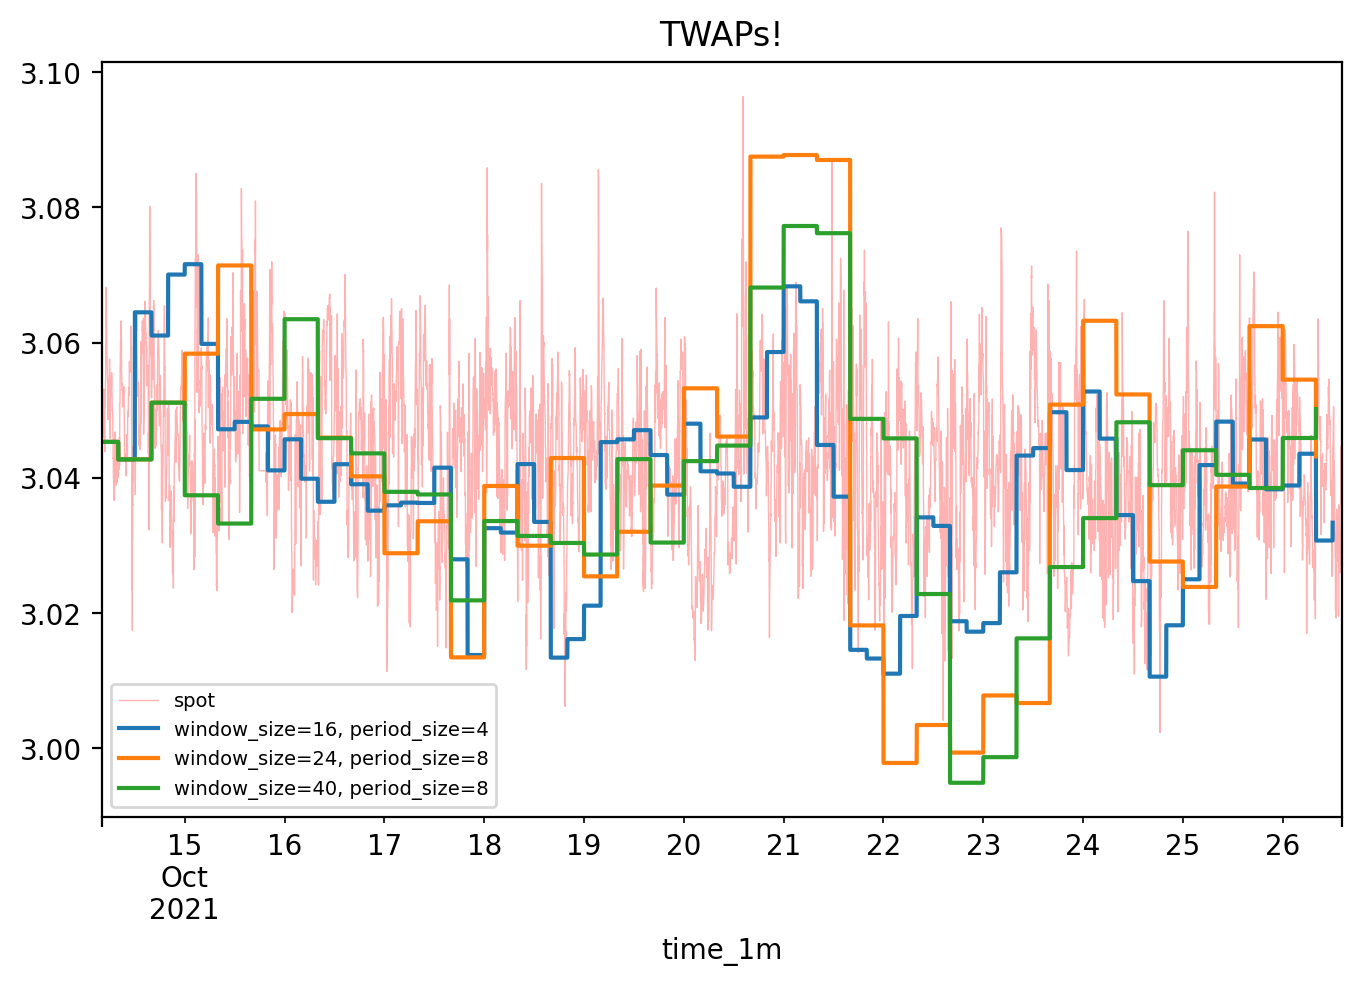

In [37]:
# spot rai/usd
ax = df['rai_usd'][:N_PLOTS].plot(alpha=0.3, color='red', label='spot', lw=0.5)

# prod twap
#t['twap_usd'][-N_PLOTS:].plot(ax=ax, alpha=0.5, color='blue', label='prod twap')

#recreate prod
"""
t = create_prod_twap(df, 16, 4, 'eth_usd_link')
twap_col = '_'.join(map(str, ['rai_usd', 16, 4]))
t[twap_col][-N_PLOTS:].plot(alpha=0.5, color='grey', label=f'recreate prod 16 4', ax=ax)
"""


for window_size, period_size in params:
    t = create_prod_twap(df, window_size, period_size, 'eth_usd_link')
    twap_col = '_'.join(map(str, ['rai_usd', window_size, period_size]))
    t[twap_col][:N_PLOTS].plot(label=f'{window_size=}, {period_size=}', ax=ax)
plt.title('TWAPs!')
plt.legend(fontsize=7)


## Create Simulated Chainlink RAI/USD Feed from RAI/USD spot data

In [38]:
# Simulate Chainlink feed from spot feed using Chainlink's deviation_threshold and staleness parameters
def threshold_deviation(df, col, threshold=0.005, stale_secs=3600):
    existing_prices = df[col].values 
    
    last_answer = existing_prices[0]
    last_time = df.index.array[0]
    prices = [last_answer]
    for i, this_price in list(enumerate(existing_prices))[1:]:
        pct_dev = abs(1 - this_price/last_answer)
        this_time = df.index.array[i]
        time_delta_sec = (this_time - last_time).seconds
        time_delta_day = (this_time - last_time).days
        time_delta = time_delta_day * 86400 + time_delta_sec
        
        #print(f"{this_time=}, {last_time=}, {time_delta=}")
        if pct_dev > threshold or time_delta >= stale_secs: 
            #print(f"Getting new {this_price=}, {last_answer=}, {pct_dev=}, {time_delta=}")
            prices.append(this_price)
            last_answer = this_price
            last_time = this_time
            
        else:
            #print(f"Using old {this_price=}, {last_answer=}, {pct_dev=}, {time_delta=}")
            prices.append(last_answer)
    
    df_thresh = df.copy()
    df_thresh[col] = np.array(prices)
    
    return df_thresh 

In [39]:
# CL RAI/USD has deviation_threshold=2% and staleness=86400
df_thresh2 = threshold_deviation(df, 'rai_usd', 0.02, 86400)

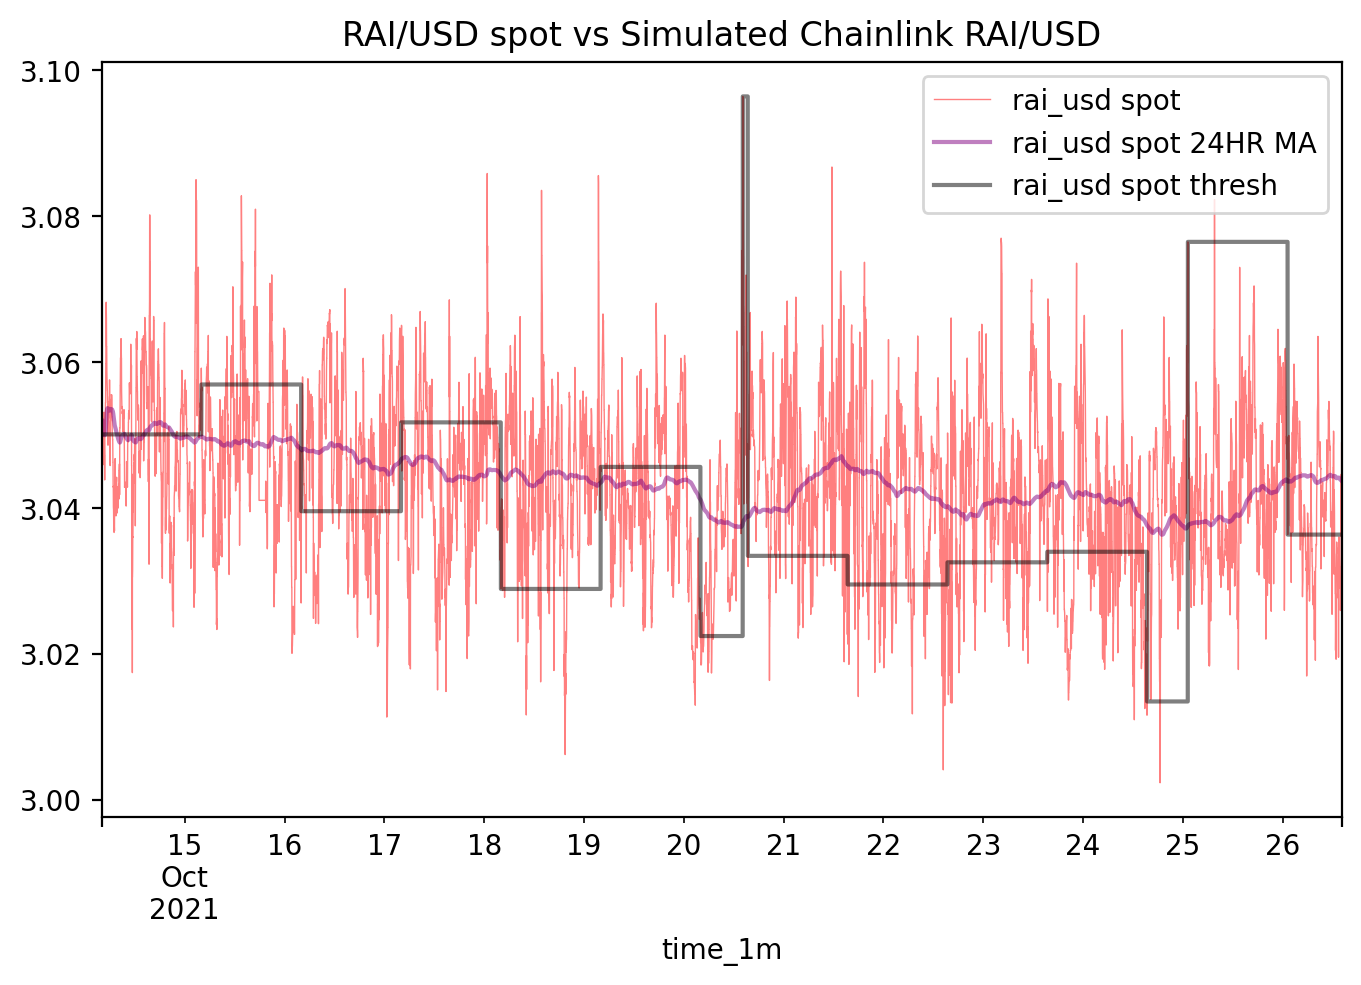

In [40]:
ax = df['rai_usd'][:100000].plot(alpha=0.5, color='red', label='rai_usd spot', lw=0.5)
df['rai_usd'][:100000].rolling('24H').mean().plot(ax=ax, alpha=0.5, color='purple', label='rai_usd spot 24HR MA')
df_thresh2['rai_usd'][:100000].plot(ax=ax, alpha=0.5, color='black', label='rai_usd spot thresh')
plt.title('RAI/USD spot vs Simulated Chainlink RAI/USD')
plt.legend()

In [42]:
# Create TWAP directly from RAI/USD
def create_new_twap(df, window_size, period_size, rai_usd_col):
    twap_col = '_'.join(map(str, [rai_usd_col, window_size, period_size]))
    
    df_twap = df.resample(str(period_size) + 'H').first()[[rai_usd_col]]
    
    df_twap[twap_col] = df_twap.rolling(str(window_size) + 'H')[rai_usd_col].mean()
    
    df_twap = df_twap.asfreq('1min', method='ffill').drop(rai_usd_col, axis=1)
    
    df_final = pd.merge(df, df_twap, left_index=True, right_index=True)
    
    return df_final  

# Create TWAP directly from RAI/USD

def create_new_twap2(df, window_size, period_size, rai_usd_col):
    twap_col = '_'.join(map(str, [rai_usd_col, window_size, period_size]))
    
    df_twap = df.resample(str(period_size) + 'H').first()[[rai_usd_col]]
    
    df_twap[twap_col] = df_twap.rolling(str(window_size) + 'H')[rai_usd_col].mean()
    
    df_twap = df_twap.asfreq('1min', method='ffill').drop(rai_usd_col, axis=1)
    
    df_final = pd.merge(df, df_twap, left_index=True, right_index=True)
    
    return df_final  

In [43]:
df_simulated_thresh = create_new_twap(df_thresh2, 40, 8, 'rai_usd')

### TWAP w/ simulated Chainlink feed vs Prod TWAP

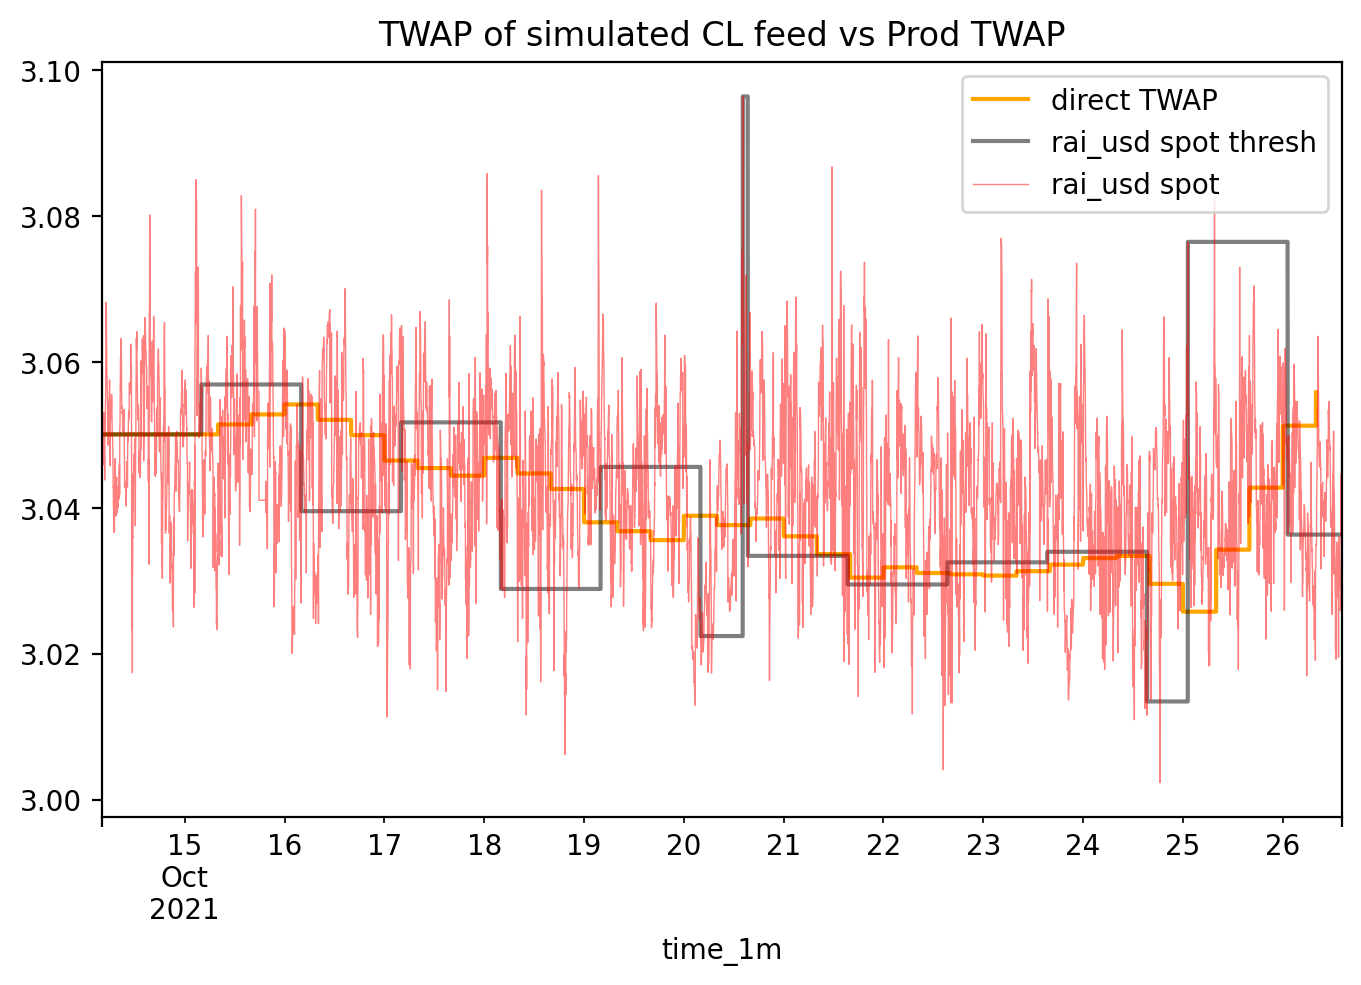

In [44]:
ax = df_simulated_thresh['rai_usd_40_8'][:N_PLOTS].plot(color='orange', label='direct TWAP')
#df_ethlink['rai_usd_16_4'][:N_PLOTS].plot(ax=ax, color='blue', label='prod twap')
df_thresh2['rai_usd'][:N_PLOTS].plot(ax=ax, alpha=0.5, color='black', label='rai_usd spot thresh')
df['rai_usd'][:N_PLOTS].plot(ax=ax, alpha=0.5, color='red', label='rai_usd spot', lw=0.5)
#df_direct_thresh['rai_usd'][:N_PLOTS].plot(ax=ax, alpha=0.5, color='black', label='rai_usd spot thresh', lw=0.5)
#df_direct['rai_usd'].rolling('16H').mean()[:N_PLOTS].plot(ax=ax, alpha=0.5, color='black', label='rai_usd 16H MA')
plt.title('TWAP of simulated CL feed vs Prod TWAP')
plt.legend()

## Actual(not simulated) Chainlink RAI/USD Feed

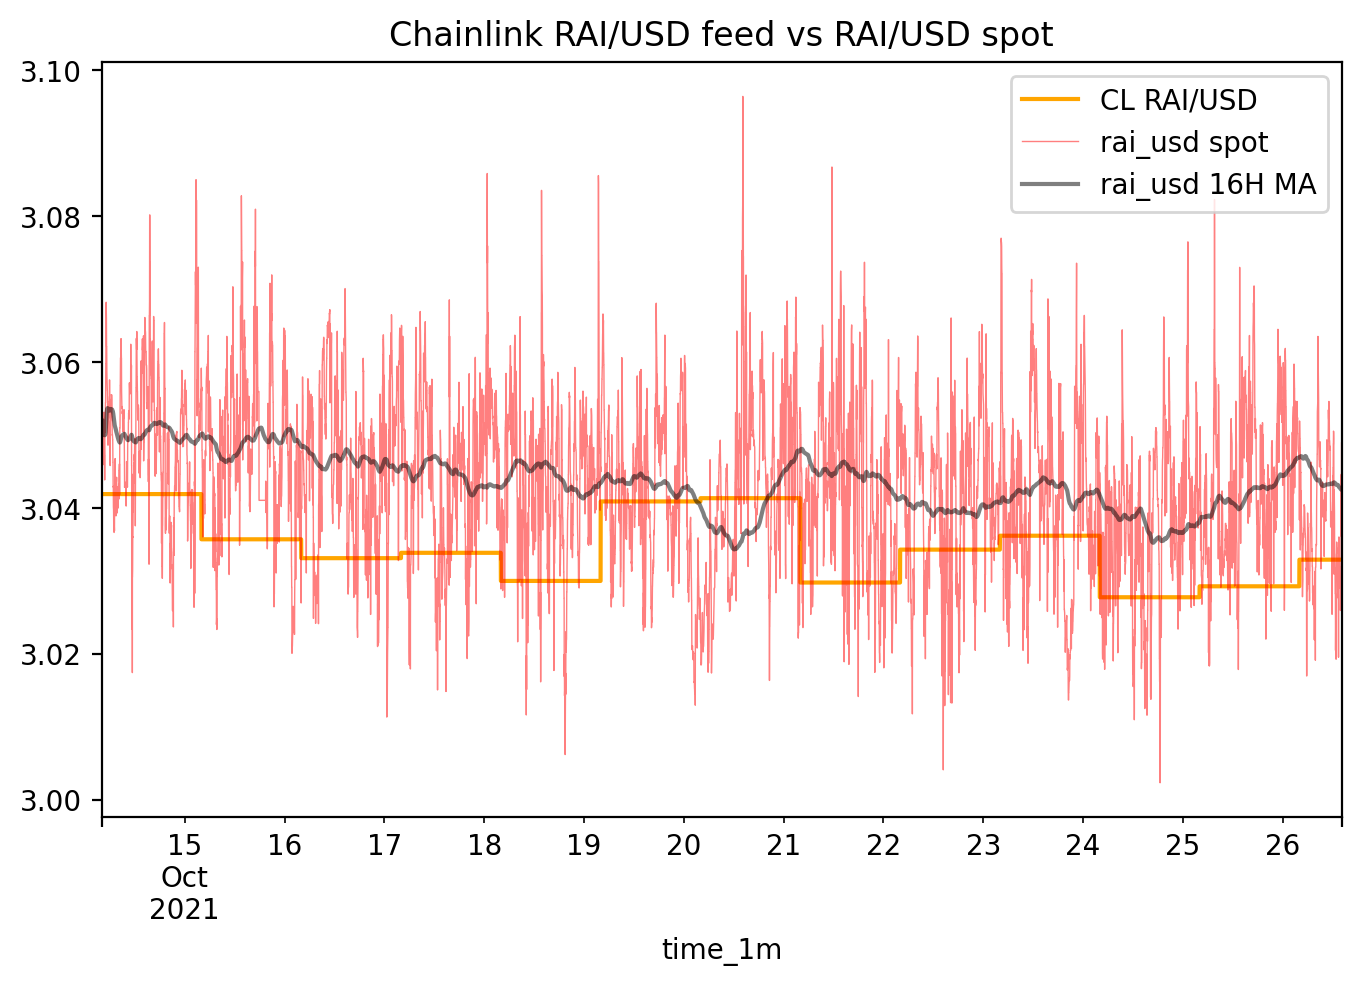

In [56]:
ax = df['rai_usd_link'][:N_PLOTS].plot(color='orange', label='CL RAI/USD')
#df_ethlink['rai_usd_16_4'][:N_PLOTS].plot(ax=ax, color='blue', label='prod twap')
df['rai_usd'][:N_PLOTS].plot(ax=ax, alpha=0.5, color='red', label='rai_usd spot', lw=0.5)
#df_direct_thresh['rai_usd'][:N_PLOTS].plot(ax=ax, alpha=0.5, color='black', label='rai_usd spot thresh', lw=0.5)
df['rai_usd'].rolling('16H').mean()[:N_PLOTS].plot(ax=ax, alpha=0.5, color='black', label='rai_usd 16H MA')
plt.title('Chainlink RAI/USD feed vs RAI/USD spot')
plt.legend()

In [46]:
df_direct_cl = create_new_twap(df_thresh2, 40, 8, 'rai_usd_link')

## TWAP of Chainlink feed vs Prod TWAP

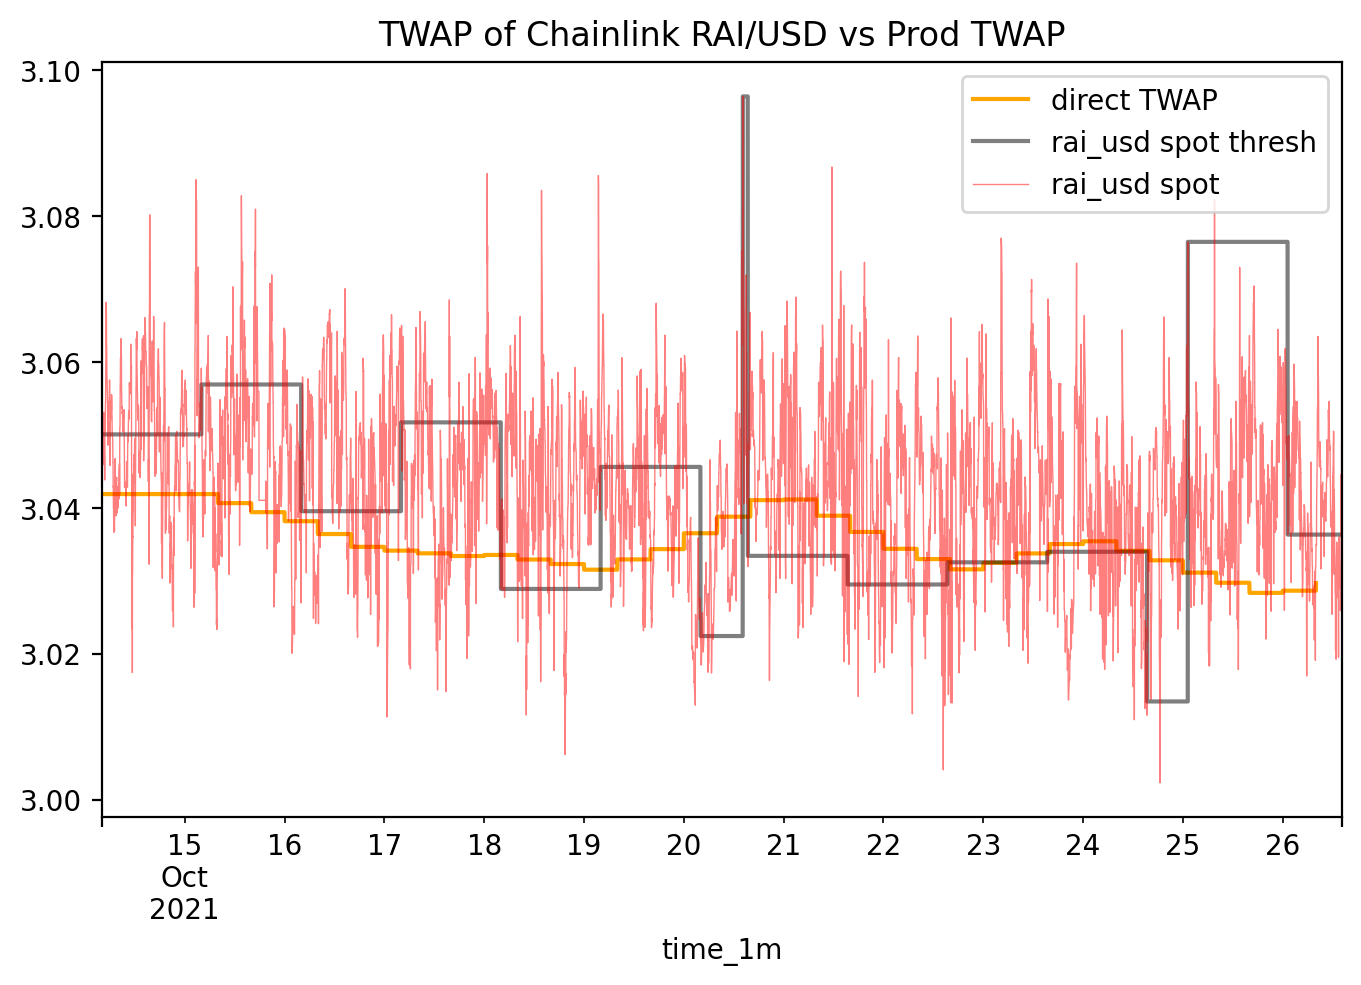

In [47]:
ax = df_direct_cl['rai_usd_link_40_8'][:N_PLOTS].plot(color='orange', label='direct TWAP')
#df_ethlink['rai_usd_16_4'][:N_PLOTS].plot(ax=ax, color='blue', label='prod twap')
df_thresh2['rai_usd'][:N_PLOTS].plot(ax=ax, alpha=0.5, color='black', label='rai_usd spot thresh')
df['rai_usd'][:N_PLOTS].plot(ax=ax, alpha=0.5, color='red', label='rai_usd spot', lw=0.5)
#df_direct_thresh['rai_usd'][:N_PLOTS].plot(ax=ax, alpha=0.5, color='black', label='rai_usd spot thresh', lw=0.5)
#df_direct['rai_usd'].rolling('16H').mean()[:N_PLOTS].plot(ax=ax, alpha=0.5, color='black', label='rai_usd 16H MA')
plt.title('TWAP of Chainlink RAI/USD vs Prod TWAP')
plt.legend()

## Actual TWAP of Chainlink RAI/USD

### Reconstructed TWAP vs RAI/USD spot and RAI/USD spot 16-hour moving average

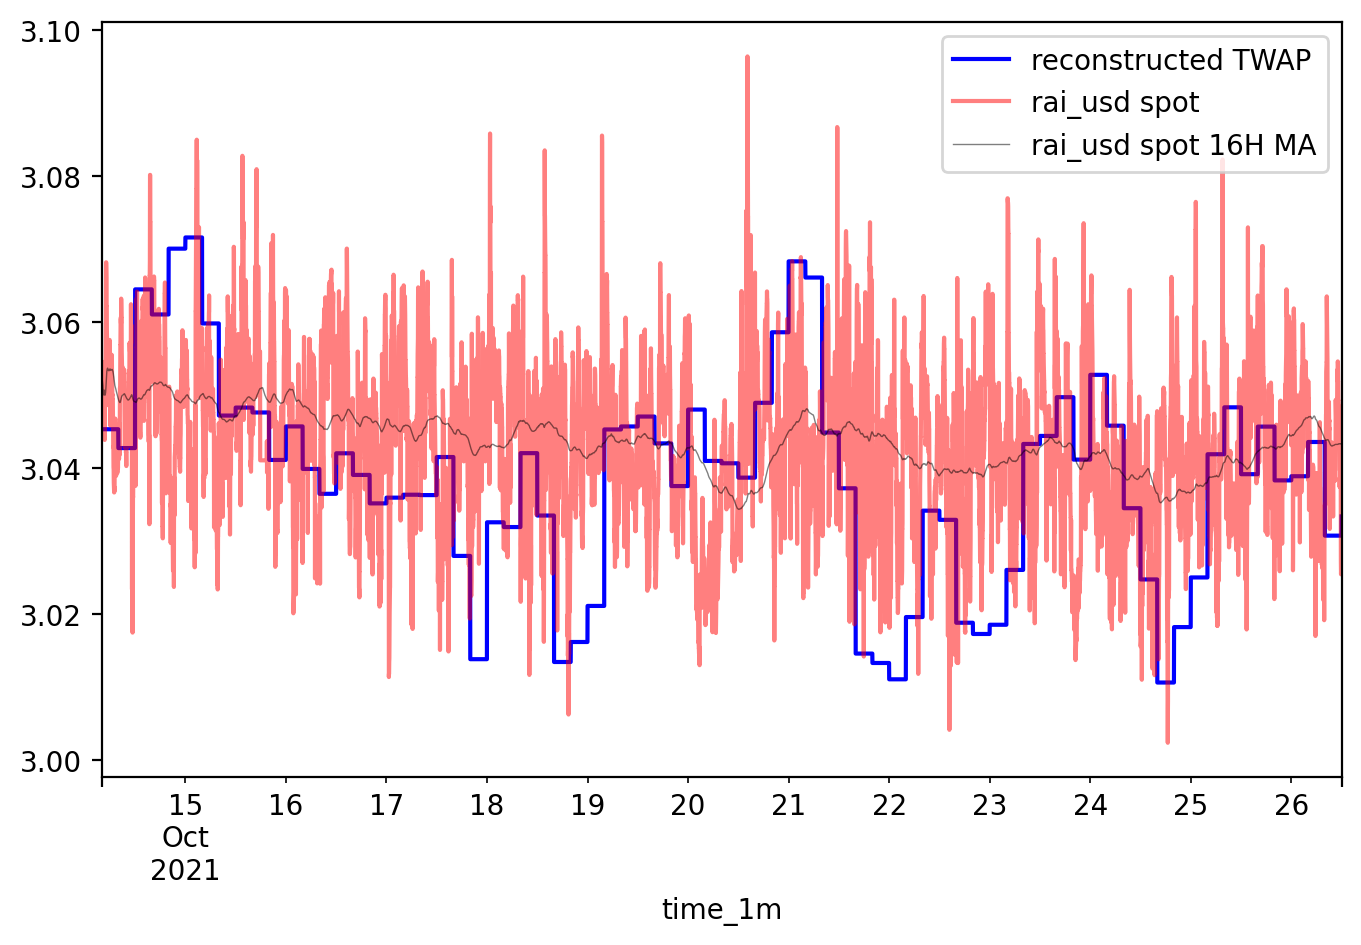

In [48]:
ax = df_ethlink['rai_usd_16_4'][-N_PLOTS:].plot(color='blue', label='reconstructed TWAP')
df_ethlink['rai_usd'][-N_PLOTS:].plot(ax=ax, alpha=0.5, color='red', label='rai_usd spot')
df_ethlink['rai_usd'].rolling('16H').mean()[-N_PLOTS:].plot(ax=ax, alpha=0.5, color='black', label='rai_usd spot 16H MA', lw=0.5)
#plt.title('TWAP #2')
plt.legend()

### TWAP #2 - RAI/USD Spot

Text(0.5, 1.0, 'TWAP #2 - RAI/USD Spot')

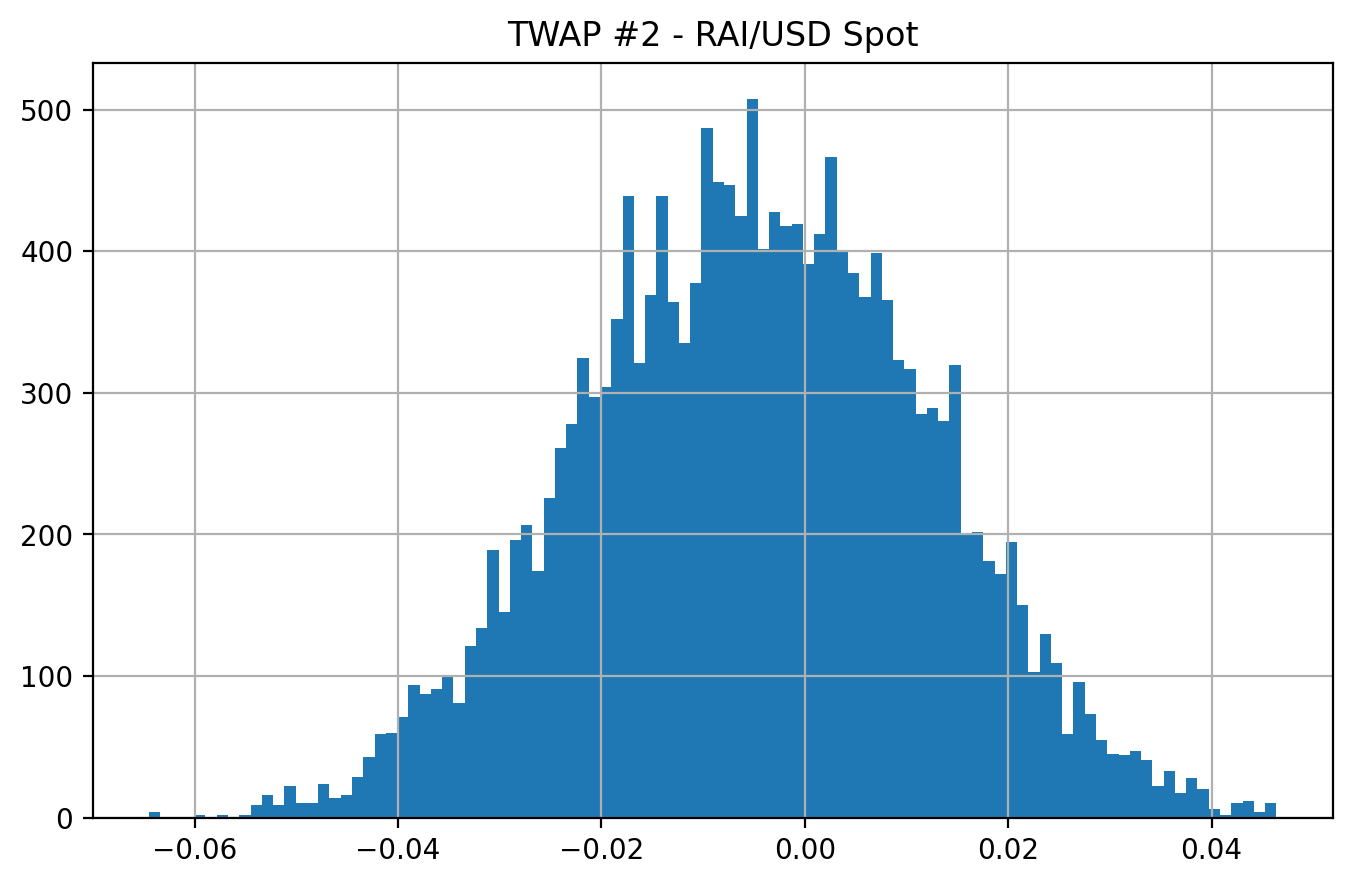

In [49]:
(df_ethlink['rai_usd_16_4'] - df_ethlink['rai_usd']).hist(bins=100)
plt.title('TWAP #2 - RAI/USD Spot')

### Create RAI/USD TWAP from spot prices, but with 16H ETH/USD TWAP w/ 1m data

In [50]:
def create_1m_twap(df, eth_usd_col):
    
    # RAI/ETH 16H TWAP
    df['rai_eth_16H'] = df.rolling('16H')['rai_eth'].mean()
    
    # Get ETH/USD value every 1 min
    df_eth_usd_1min = df.resample('1min').first()[[eth_usd_col, 'rai_eth_16H']]
    
    # Calculate 16H ETH/USD moving average
    df_eth_usd_1min['eth_usd_16H'] = df_eth_usd_1min.rolling('16H')[eth_usd_col].mean()
       
    # Reconstruct Prod RAI/USD TWAP by multiplying RAI/ETH TWAP with 16H ETH/USD TWAP
    df_eth_usd_1min['twap_16H_usd'] = df_eth_usd_1min['rai_eth_16H'] * df_eth_usd_1min['eth_usd_16H']
    
    # Forward fill values every min
    df_eth_usd_1min = df_eth_usd_1min.asfreq('1min', method='ffill')
    
    df_final = pd.merge(df, df_eth_usd_1min, left_index=True, right_index=True).drop([eth_usd_col + '_x', eth_usd_col + '_y'], axis=1)
    
    return df_final

In [51]:
df3 = create_1m_twap(df, 'eth_usd_link')

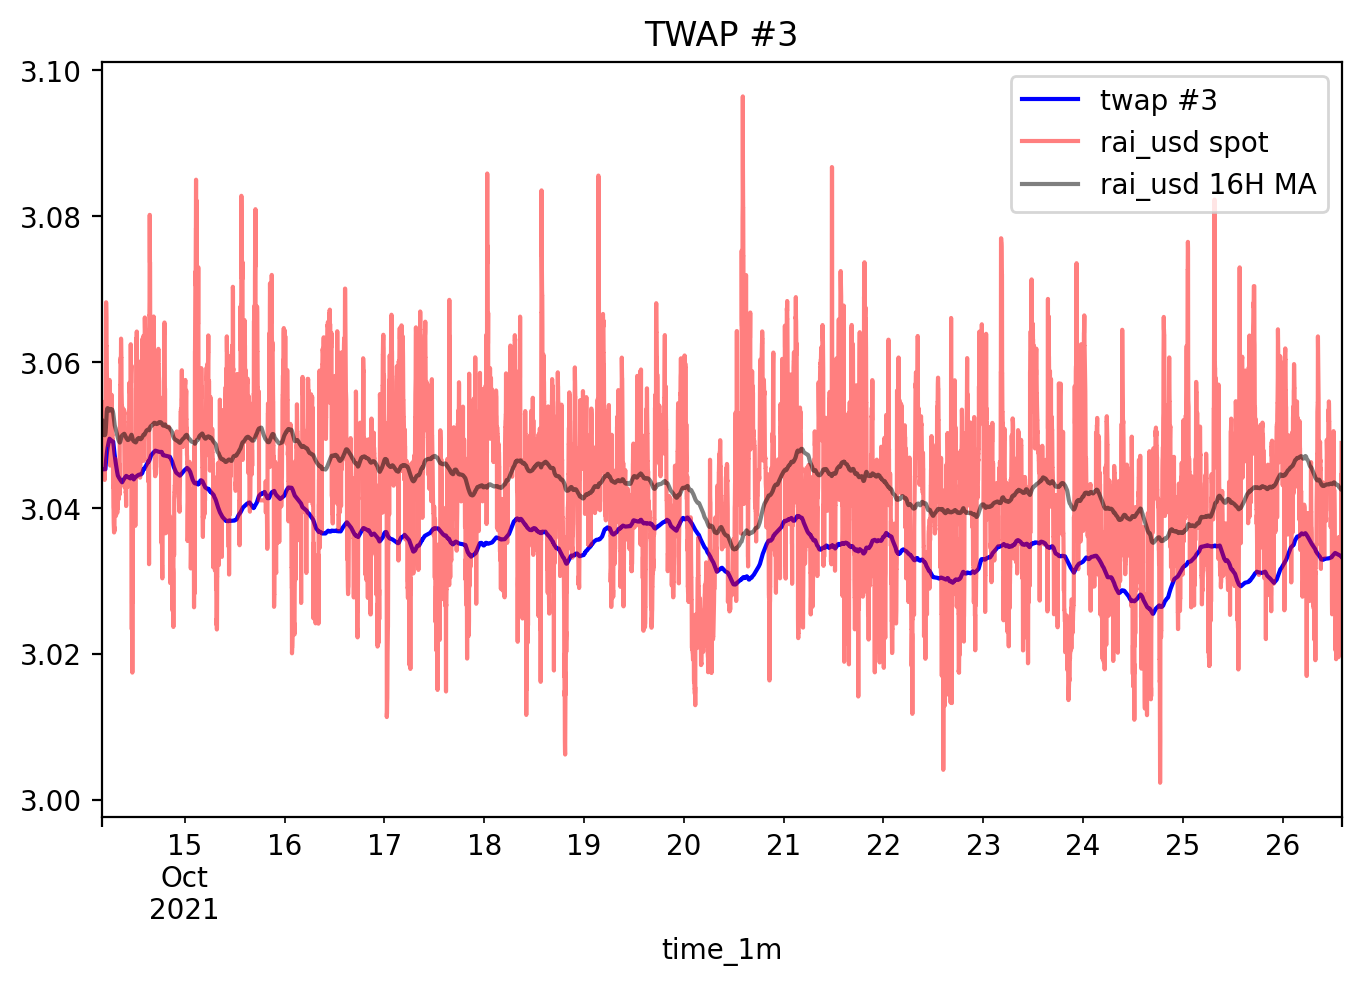

In [52]:
ax = df3['twap_16H_usd'][-N_PLOTS:].plot(color='blue', label='twap #3')
df3['rai_usd'][-N_PLOTS:].plot(ax=ax, alpha=0.5, color='red', label='rai_usd spot')
df3['rai_usd'].rolling('16H').mean()[-N_PLOTS:].plot(ax=ax, alpha=0.5, color='black', label='rai_usd 16H MA')
plt.title('TWAP #3')
plt.legend()

### Compare 1min TWAP with prod RAI/USD TWAP

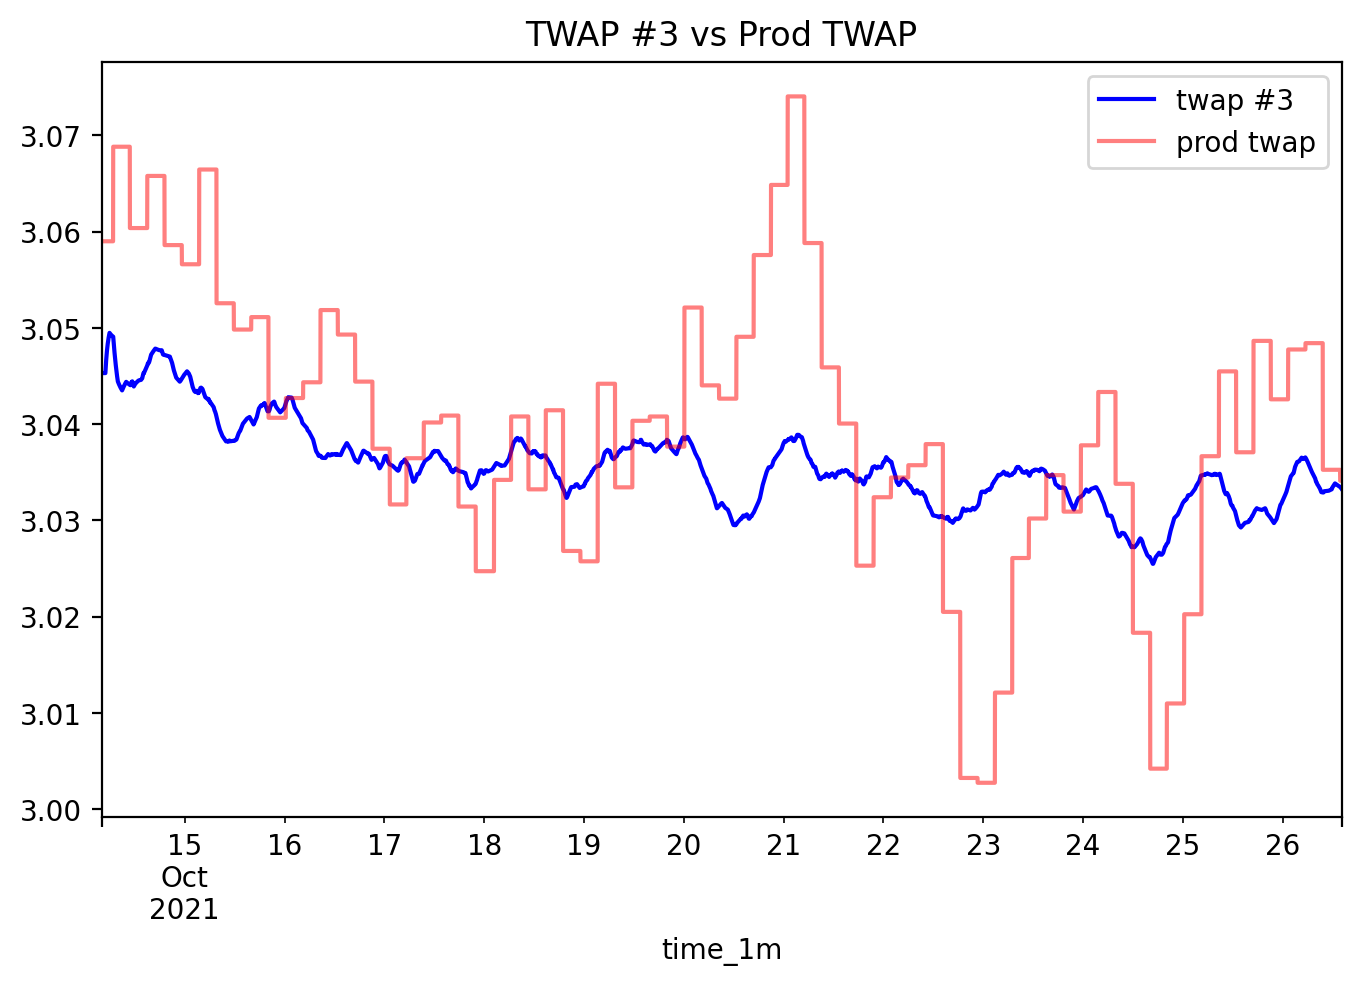

In [53]:
ax = df3['twap_16H_usd'][-N_PLOTS:].plot(color='blue', label='twap #3')
df3['twap_usd'][-N_PLOTS:].plot(ax=ax, alpha=0.5, color='red', label='prod twap')
plt.title('TWAP #3 vs Prod TWAP')
plt.legend()

# New TWAP: Simulate a direct RAI/USD Chainlink Feed

In [54]:
def create_new_twap(df, window_size, period_size, rai_col):
    twap_col = '_'.join(map(str, [rai_usd_col, window_size, period_size]))
    
    df_twap = df.resample(str(period_size) + 'H').first()[[rai_usd_col]]
    
    df_twap[twap_col] = df_twap.rolling(str(window_size) + 'H')[rai_usd_col].mean()
    
    df_twap = df_twap.asfreq('1min', method='ffill').drop(rai_usd_col, axis=1)
    
    df_final = pd.merge(df, df_twap, left_index=True, right_index=True)
    
    return df_final  

In [55]:
df_direct = create_new_twap(df, 16, 4)

TypeError: create_new_twap() missing 1 required positional argument: 'rai_col'

### Direct TWAP vs Prod TWAP

In [ ]:
ax = df_direct['rai_usd_16_4'][:N_PLOTS].plot(color='orange', label='direct TWAP')
ax = df_ethlink['rai_usd_16_4'][:N_PLOTS].plot(color='blue', label='prod twap')
df_direct['rai_usd'][:N_PLOTS].plot(ax=ax, alpha=0.5, color='red', label='rai_usd spot', lw=0.5)
#df_direct['rai_usd'].rolling('16H').mean()[:N_PLOTS].plot(ax=ax, alpha=0.5, color='black', label='rai_usd 16H MA')
plt.title('Direct TWAP vs Prod TWAP')
plt.legend()

In [ ]:
params = [(16, 4), (24, 8), (40, 8)]

In [ ]:
# prod twap
#ax = t['twap_usd'][-N_PLOTS:].plot(alpha=0.5, color='black', label='prod twap')

# spot rai/usd
ax = t['rai_usd'][-N_PLOTS:].plot(alpha=0.3, color='red', label='spot', lw=0.5)

#recreate prod
#t = create_twap(df, 16, 4)
#twap_col = '_'.join(map(str, ['rai_usd', 16, 4]))
#t[twap_col][-N_PLOTS:].plot(alpha=0.5, color='grey', label=f'recreate prod 16 4', ax=ax)

for window_size, period_size in params:
    print(window_size, period_size)
    t = create_new_twap(df, window_size, period_size)
    twap_col = '_'.join(map(str, ['rai_usd', window_size, period_size]))
    t[twap_col][-N_PLOTS:].plot(label=f'{window_size=}, {period_size=}', ax=ax)
    
plt.title('Direct RAI/USD TWAPs')
plt.legend(fontsize=8)   